## Punto 2
Importar datos

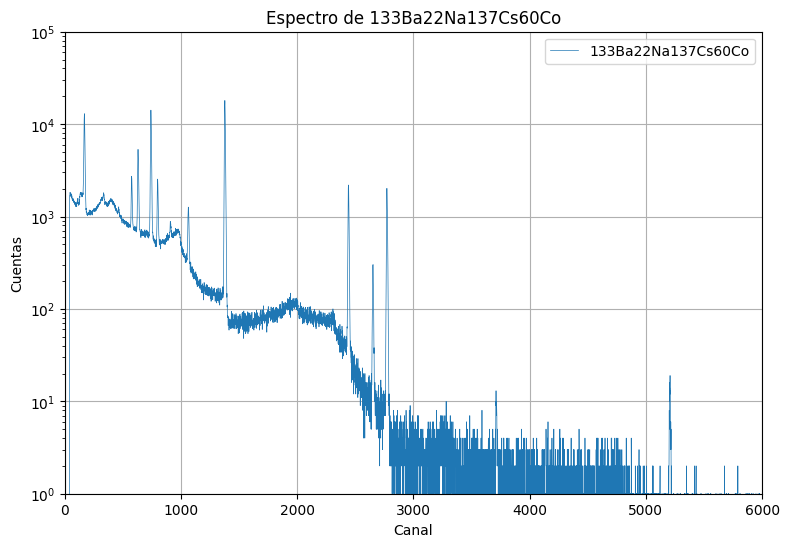

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# datos de calibración
# data_cal = np.loadtxt('files/calibracion.txt')
# importar datos csv con encabezados

data_cal = np.genfromtxt('2021-11-15_cal_133Ba22Na137Cs60Co_600s_1.csv', delimiter=',', skip_header=1)
canales = data_cal[:,0]
cuentas = data_cal[:,1]
fuente = '133Ba22Na137Cs60Co'

# La fuente de calibración es Ba-133, Na-22, Cs-137 y Co-60
def plotear_espectro(canales, cuentas, fuente, xlim=None, logplot=True, size=(9, 6)):
    plt.figure(figsize=size)
    plt.plot(canales, cuentas, label=fuente, linewidth=0.5)
    plt.xlabel('Canal')
    plt.ylabel('Cuentas')
    plt.title(f'Espectro de {fuente}')
    plt.grid()
    if logplot:
        plt.yscale('log')
        plt.ylim(1, 10**(np.ceil(np.log10(max(cuentas)))))
    else:
        plt.ylim(1, max(cuentas)+100)
    if xlim is not None:
        plt.xlim(0, xlim)
    else:
        plt.xlim(0, max(canales))
    plt.legend()
    plt.show()

plotear_espectro(canales, cuentas, fuente, xlim=6000)
# plotear_espectro(canales, cuentas, fuente, xlim=6000, logplot=False)

In [2]:
# lista de energías de los picos de calibración

values = {'22Na_1': 1274.537,
             '60Co_1': 1173.228,
             '60Co_2': 1332.490,
             '137Cs_1': 661.657,
             '137Cs_alfa':32.06,
             '133Ba_1': 53.1625,
             '133Ba_2': 79.6139,
             '133Ba_3': 80.9971,
             '133Ba_4': 160.6109,
             '133Ba_5': 223.2373,
             '133Ba_6': 276.3997,
             '133Ba_7': 302.8510,
             '133Ba_8': 356.0134,
             '133Ba_9': 383.8480}


values_sorted = sorted(values.items(), key=lambda x: x[1])

p_energia = [(key, value) for key, value in values_sorted if key not in ['137Cs_alfa', '137Cs_beta', '133Ba_1', '133Ba_2', '133Ba_4', '133Ba_5']]

import pandas as pd
f_calibracion = pd.DataFrame(p_energia, columns=['Fuente', 'E_gamma (keV)'])
f_calibracion


,Fuente,E_gamma (keV)
0,133Ba_3,80.9971
1,133Ba_6,276.3997
2,133Ba_7,302.8510
3,133Ba_8,356.0134
4,133Ba_9,383.8480
5,137Cs_1,661.6570
6,60Co_1,1173.2280
7,22Na_1,1274.5370
8,60Co_2,1332.4900


In [3]:
#Funcion para plotear un pico de interés
def plotear_pico(canales, cuentas, fuente, canal, anchocanal=20):
    plt.figure(figsize=(10, 7))
    plt.plot(canales, cuentas, label=fuente)
    plt.xlabel('Canal')
    plt.ylabel('Cuentas')
    plt.title(f'Espectro de {fuente}')
    plt.yscale('log')
    plt.grid()
    plt.xlim(canal-anchocanal, canal+anchocanal)
    plt.legend()
    plt.show()

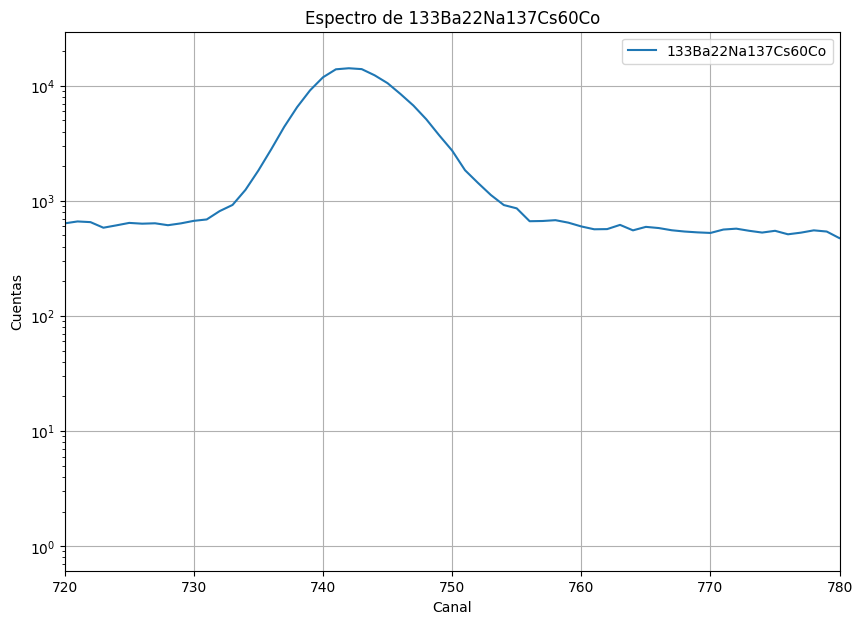

In [4]:
# Lista de canales de los picos de calibración

plotear_pico(canales, cuentas, fuente, 750, anchocanal=30)

In [5]:
#funcion para plotear canal energia en un mismo scatter
def plot_canal_energia(data, canal):
   
    fig, ax1 = plt.subplots()

    energia = data['E_gamma (keV)']

    ax1.scatter(range(len(canal)), canal, color='red', label='Canal estimado')
    ax1.set_ylabel('p_canal_estimado')

    ax2 = ax1.twinx()

    ax2.scatter(range(len(energia)), energia, color='blue',marker='x', label='Energia')
    ax2.set_ylabel('p_energia')

    ax1.set_xticks(range(max([len(energia),len(canal)])))
    ax1.set_xticklabels(range(max([len(energia),len(canal)])))

    ax1.legend(loc='upper left')
    ax2.legend(loc='center left')

    plt.show()

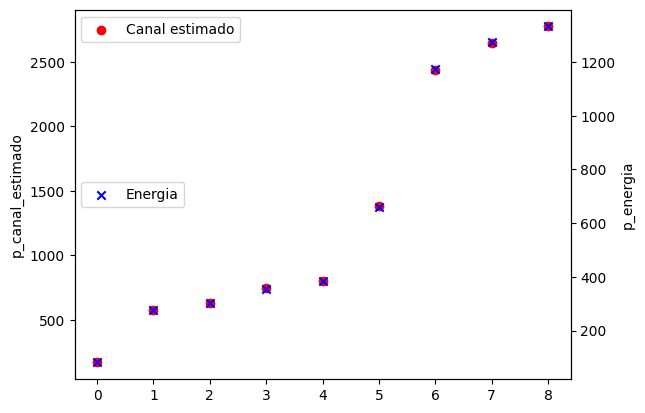

In [6]:

p_canal_estimado = [170, 575, 630, 745, 800, 1380, 2440, 2650, 2775]

# ir recortando valores de energia hasta que las graficas se correspondan
plot_canal_energia(f_calibracion, p_canal_estimado)

In [7]:
# agregar las energias a sus respectivos picos añadiendolos al dataframe

f_calibracion['Canal estimado'] = p_canal_estimado
f_calibracion

,Fuente,E_gamma (keV),Canal estimado
0,133Ba_3,80.9971,170
1,133Ba_6,276.3997,575
2,133Ba_7,302.8510,630
3,133Ba_8,356.0134,745
4,133Ba_9,383.8480,800
5,137Cs_1,661.6570,1380
6,60Co_1,1173.2280,2440
7,22Na_1,1274.5370,2650
8,60Co_2,1332.4900,2775


In [8]:
# Funciones gaussianas para el ajuste de los picos

def gaussiana_lineal(x, a, x0, sigma, b_0, b_1):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + b_0 + b_1*x

def gaussiana(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))
# Se define un rango de ajuste para cada fotopico


In [9]:
# Ajuste de gaussiana al rededor de cada fotopico de e_canal_cal

from scipy.optimize import curve_fit
def ajustar_gaussiana_lineal(data, canales, cuentas):
    rango_ajuste = [(c-30, c+30) for c in data['Canal estimado']]
    # Se define un rango de ajuste para cada fotopico
    # los parametros optimos son guardados en popt y la covarianza en pcov
    # popt_i = [a, x0, sigma] para el i-esimo fotopico
    # pcov_i = matriz de covarianza para el i-esimo fotopico
    # a = amplitud, x0 = centro, sigma = desviacion estandar
    popt = []
    pcov = []
    for i in range(len(rango_ajuste)):
        popt_i, pcov_i = curve_fit(gaussiana_lineal, canales[rango_ajuste[i][0]:rango_ajuste[i][1]], cuentas[rango_ajuste[i][0]:rango_ajuste[i][1]], p0=[max(cuentas[rango_ajuste[i][0]:rango_ajuste[i][1]]), f_calibracion['Canal estimado'][i], 10, 0, 0])
        popt.append(popt_i)
        pcov.append(pcov_i)

    incertidumbres = np.sqrt(np.diagonal(pcov, axis1=1, axis2=2))

    data['A (cuentas)'] = [round(popt_i[0],2) for popt_i in popt]
    data['dA (cuentas)'] = [round(incertidumbres_i[0],2) for incertidumbres_i in incertidumbres]
    data['Canal'] = [round(popt_i[1],2) for popt_i in popt]
    data['dCanal'] = [round(incertidumbres_i[1],2) for incertidumbres_i in incertidumbres]
    data['sigma (Canales)'] = [round(popt_i[2],2) for popt_i in popt]
    data['dSigma (Canales)'] = [round(incertidumbres_i[2],2) for incertidumbres_i in incertidumbres]

    return f_calibracion

f_calibracion = ajustar_gaussiana_lineal(f_calibracion, canales, cuentas)
f_calibracion

,Fuente,E_gamma (keV),Canal estimado,A (cuentas),dA (cuentas),Canal,dCanal,sigma (Canales),dSigma (Canales)
0,133Ba_3,80.9971,170,11169.65,88.82,170.07,0.03,3.55,0.03
1,133Ba_6,276.3997,575,1899.16,22.38,576.79,0.05,3.42,0.05
2,133Ba_7,302.8510,630,4550.64,48.73,631.85,0.04,3.58,0.05
3,133Ba_8,356.0134,745,13494.56,136.65,742.45,0.04,3.57,0.04
4,133Ba_9,383.8480,800,1921.73,21.87,800.33,0.05,3.62,0.05
5,137Cs_1,661.6570,1380,17574.63,150.32,1378.20,0.04,3.60,0.04
6,60Co_1,1173.2280,2440,2158.12,18.05,2441.69,0.04,3.74,0.04
7,22Na_1,1274.5370,2650,290.65,3.85,2652.08,0.05,3.63,0.06
8,60Co_2,1332.4900,2775,1917.39,24.79,2772.46,0.06,3.78,0.06


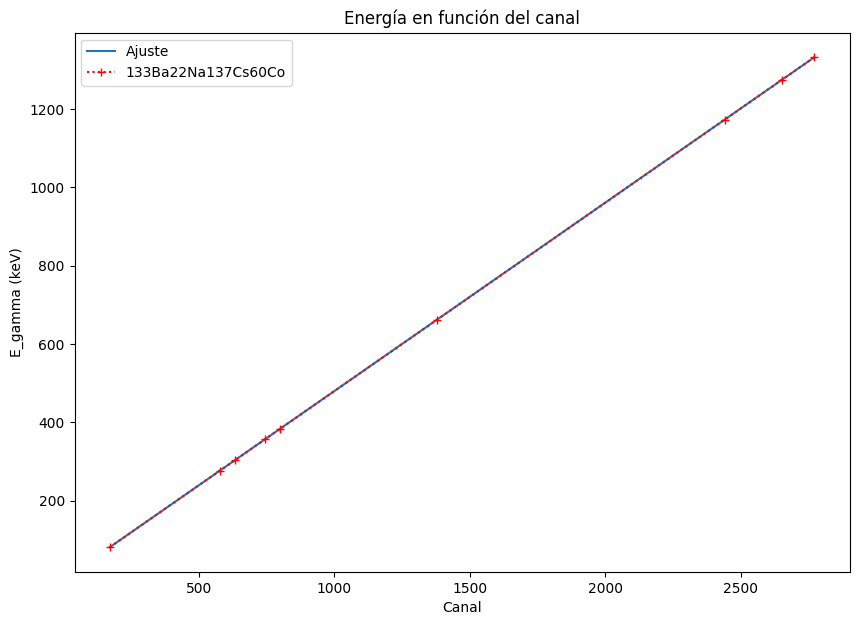

,parametro,valor,incertidumbre
0,a_1,0.480936,0.000042
1,a_0,-1.001274,0.068993


In [10]:
# Ajuste lineal Energia vs Canal

from scipy.stats import linregress

a_1, a_0, r_value, p_value, std_err = linregress(f_calibracion['Canal'], f_calibracion['E_gamma (keV)'])

# Los errores de la pendiente y la ordenada al origen son:

incert_a_1 = std_err
incert_a_0 = std_err*np.sqrt(np.mean(f_calibracion['Canal']**2))

# plot the adjusted values of the counts for each channel
plt.figure(figsize=(10, 7))
plt.plot(f_calibracion['Canal'], a_1*f_calibracion['Canal']+a_0, label='Ajuste')
plt.plot(f_calibracion['Canal'], f_calibracion['E_gamma (keV)'], 'r+:', label=fuente)
plt.xlabel('Canal')
plt.ylabel('E_gamma (keV)')
plt.title('Energía en función del canal')
plt.legend()
plt.show()


data3 = {
    'parametro' : ['a_1', 'a_0'],
    'valor' : [a_1, a_0],
    'incertidumbre' : [incert_a_1, incert_a_0]
}

df_3 = pd.DataFrame(data3)
df_3

## Punto 3
Da información del experimento

## Punto 4
importar datos

In [11]:
def plot_espectro_kev(canales, energia, fuente, xlim=None, logplot=True, size=(9, 6)):
    plt.figure(figsize=size)
    plt.plot(canales, energia, label=fuente, linewidth=0.5)
    plt.xlabel('Energia (keV)')
    plt.ylabel('Cuentas')
    plt.title(f'Espectro de {fuente}')
    plt.grid()
    if logplot:
        plt.yscale('log')
        plt.ylim(1, 10**(np.ceil(np.log10(max(energia)))))
    else:
        plt.ylim(1, max(energia)+100)
    if xlim is not None:
        plt.xlim(0, xlim)
    else:
        plt.xlim(0, max(canales))
    plt.legend()
    plt.show()

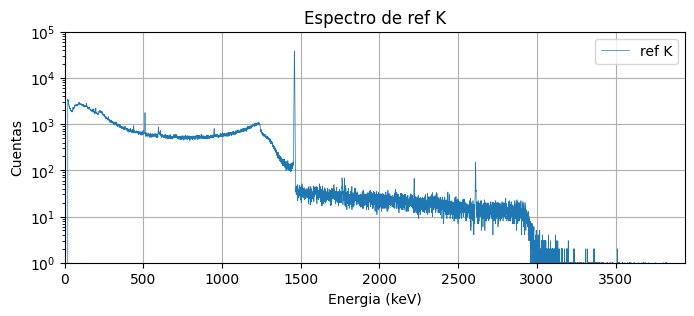

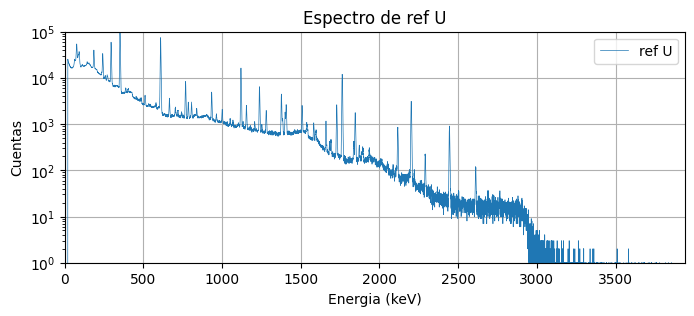

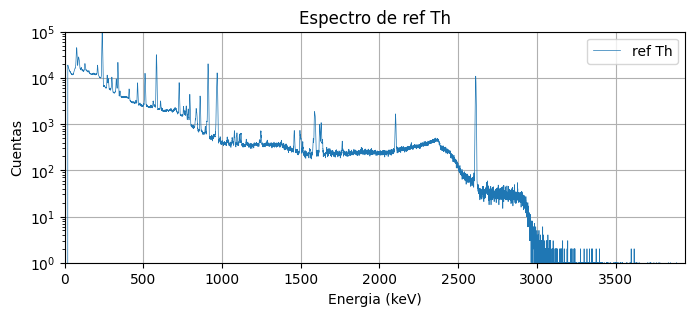

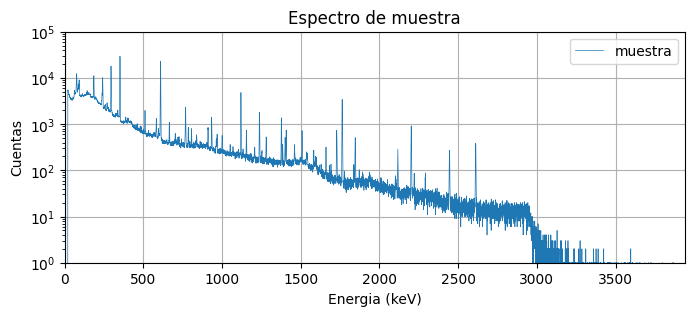

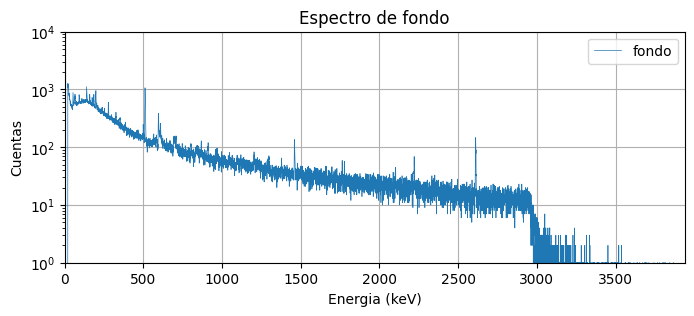

,Canal,Energía (keV),ref K,ref U,ref Th,muestra,fondo
1000,1000.0,479.935036,648.0,3705.0,2659.0,911.0,150.0
1001,1001.0,480.415972,605.0,3541.0,2696.0,899.0,140.0
1002,1002.0,480.896908,629.0,3571.0,2668.0,857.0,163.0
1003,1003.0,481.377844,632.0,3491.0,2534.0,777.0,135.0
1004,1004.0,481.858781,626.0,3350.0,2612.0,760.0,148.0
1005,1005.0,482.339717,677.0,3269.0,2610.0,771.0,160.0
1006,1006.0,482.820653,634.0,3237.0,2646.0,724.0,152.0
1007,1007.0,483.301590,635.0,3230.0,2581.0,715.0,155.0
1008,1008.0,483.782526,581.0,3105.0,2470.0,648.0,128.0
1009,1009.0,484.263462,645.0,3164.0,2548.0,653.0,135.0


In [12]:
#importa los datos de los espectros de las muestras y el fondo
nombre_datos = ['ref K', 'ref U', 'ref Th','muestra','fondo']
archivos = ['2021-11-17_mue_IAEA-RGK-1_24h.csv','2021-11-16_mue_IAEA-RGU-1_24h.csv','2021-11-15_mue_IAEA-RGTh-1_24h.csv','2021-12-04_mue_DG-EG-014_24h.csv','2021-12-15_fon_24h.csv']

# importar datos csv con encabezados en e_medido (espectro medido)
e_medido = pd.DataFrame()
e_medido['Canal'] = canales
e_medido['Energía (keV)'] = a_1*e_medido['Canal'] + a_0

for i in range(len(archivos)):
    data_i = np.genfromtxt(archivos[i], delimiter=',', skip_header=1)
    # canales_i = data_i[:,0]
    cuentas_i = data_i[:,1]
    fuente_i = nombre_datos[i]
    plot_espectro_kev(e_medido['Energía (keV)'], cuentas_i, fuente_i, size=(8, 3))
    e_medido[nombre_datos[i]] = cuentas_i

e_medido.iloc[1000:1010]

In [13]:
# Remover el fondo de los espectros de las muestras e_puro (espectro puro)

e_puro = pd.DataFrame()
e_puro['Canal'] = canales
e_puro['Energía (keV)'] = e_medido['Energía (keV)']
for i in range(len(nombre_datos)-1):
    e_puro[nombre_datos[i]] = e_medido[nombre_datos[i]] - e_medido['fondo']

e_puro

,Canal,Energía (keV),ref K,ref U,ref Th,muestra
0,0.0,-1.001274,0.0,0.0,0.0,0.0
1,1.0,-0.520337,0.0,0.0,0.0,0.0
2,2.0,-0.039401,0.0,0.0,0.0,0.0
3,3.0,0.441535,0.0,0.0,0.0,0.0
4,4.0,0.922471,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
8187,8187.0,3936.424290,0.0,0.0,0.0,0.0
8188,8188.0,3936.905227,0.0,0.0,0.0,0.0
8189,8189.0,3937.386163,0.0,0.0,0.0,0.0
8190,8190.0,3937.867099,0.0,0.0,0.0,0.0


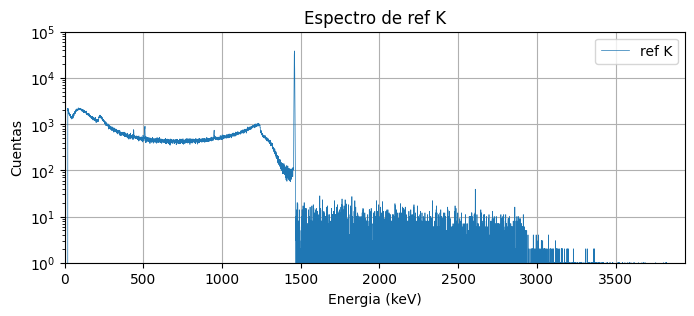

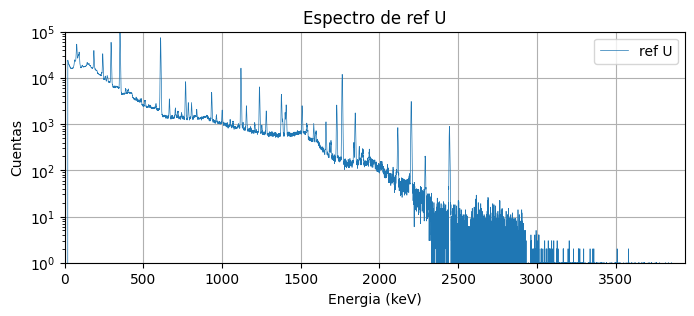

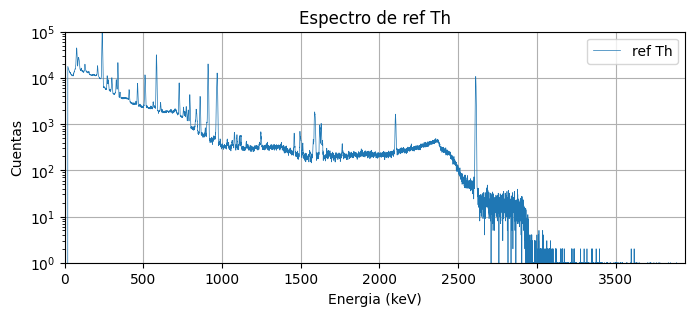

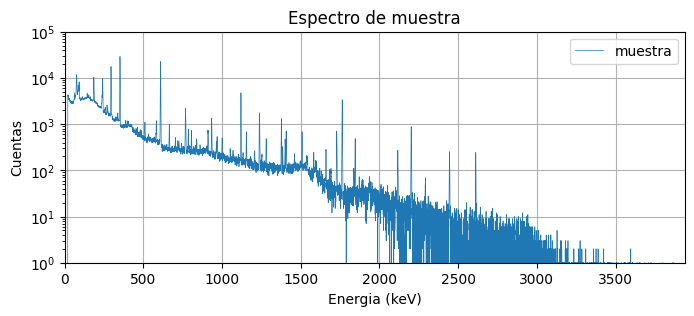

In [14]:
# Plotea los espectros puros
for i in range(len(archivos)-1):
    plot_espectro_kev(e_puro['Energía (keV)'], e_puro[nombre_datos[i]], nombre_datos[i], size=(8, 3))
